##Model Training
Several models were trained and evaluated using the Root Mean Squared Error (RMSE) metric. A TimeSeriesSplit cross-validation strategy was used where applicable to account for the temporal nature of the data.

###Linear Regression
Linear Regression was used as a baseline model. Due to the complex and nonlinear relationships between stock prices and macroeconomic indicators, Linear Regression did not perform well. However, its role is valuable as a benchmark — any model that outperforms it demonstrates added predictive value.

###Random Forest
Random Forest outperformed Linear Regression when evaluated using time series cross-validation. Its ability to model nonlinear relationships and interactions between features made it a better fit for the task.

###XGBoost
XGBoost achieved the best performance among all models. It consistently outperformed Linear Regression and Random Forest during time series cross-validation.

###LSTM Neural Network
The LSTM model tended to overfit due to the limited size of the dataset, even with a small number of training epochs. As a result, its performance on the test set was not competitive.

###ARIMA Model
An ARIMAX model was used to incorporate macroeconomic variables. Despite this, the model yielded the worst performance among all tested models, suggesting that traditional statistical methods are less effective in this context compared to machine learning models.

#Model Testing and Final Conclusion
XGBoost was selected as the final model due to its superior performance. It outperformed Linear Regression, making it the most suitable choice for predicting the GDAXI index using macroeconomic indicators but still the result is not consistent enough for practical usage

In [1]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from statsmodels.tsa.arima.model import ARIMA
from keras.losses import Huber
import joblib

In [2]:
RANDOMSTATE = 1234
#link to GitHub repo where stock price is saved
TARGET_TRAIN_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/target_train.csv'
TARGET_TRAIN_FILE_NAME = 'target_train.csv'
TARGET_TEST_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/target_test.csv'
TARGET_TEST_FILE_NAME = 'target_test.csv'
##link to GitHub repo where macroeconomics indicators are saved
FEATURE_TRAIN_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/features_train.csv'
FEATURE_TRAIN_FILE_NAME = 'features_train.csv'
FEATURE_TEST_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/features_test.csv'
FEATURE_TEST_FILE_NAME = 'features_test.csv'
##link to GitHub repo where scalers are saved
SCALER_TARGET_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/scaler_target.save'
SCALER_TARGET_FILE_NAME = 'scaler_target.save'
SCALER_FEATURES_URL = 'https://raw.githubusercontent.com/EvgeniyStrizhak/My-master-s-thesis/refs/heads/main/processed_datasets/scaler_features.save'
SCALER_FEATURES_FILE_NAME = 'scaler_features.save'

In [3]:
#geting data from url and saves it locally
def get_data(url, file_name):
  response = requests.get(url)

#Check if the request was successful
  if response.status_code == 200:
      # Save the file locally
      with open(file_name, "wb") as file:
          file.write(response.content)
      print(f"File downloaded successfully: {file_name}")
      return file_name
  else:
    print(f"Failed to download file: {file_name} Status code: {response.status_code}")
    return None

In [4]:
#function training model using GridSearchCV
def model_training (model, grid_space, features_train, target_train, cv):

#pipline to scale data before every cross validation iteration
    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('model', model)
    ])

#Apply pipline for parameter iteration function
    grid = GridSearchCV(pipeline, param_grid=grid_space, cv=cv, scoring='neg_root_mean_squared_error')
    model_grid = grid.fit(features_train, target_train)
    best_model = grid.best_estimator_

    print('The model with the best parameters: '+str(model_grid.best_params_))
#multiply negative root mean squared error by -1 to avoid confusion
    print('The best result (RMSE): '+str(model_grid.best_score_*-1))
    return best_model

In [5]:
#Download preprocessed data from GitHub
get_data(TARGET_TRAIN_URL, TARGET_TRAIN_FILE_NAME)
get_data(TARGET_TEST_URL, TARGET_TEST_FILE_NAME)
get_data(FEATURE_TRAIN_URL, FEATURE_TRAIN_FILE_NAME)
get_data(FEATURE_TEST_URL, FEATURE_TEST_FILE_NAME)
get_data(SCALER_TARGET_URL, SCALER_TARGET_FILE_NAME)
get_data(SCALER_FEATURES_URL, SCALER_FEATURES_FILE_NAME)

File downloaded successfully: target_train.csv
File downloaded successfully: target_test.csv
File downloaded successfully: features_train.csv
File downloaded successfully: features_test.csv
File downloaded successfully: scaler_target.save
File downloaded successfully: scaler_features.save


'scaler_features.save'

In [6]:
target_train = pd.read_csv('target_train.csv')
target_test = pd.read_csv('target_test.csv')
features_train = pd.read_csv('features_train.csv')
features_test = pd.read_csv('features_test.csv')
scaler_target = joblib.load('scaler_target.save')
scaler_features = joblib.load('scaler_features.save')

In [7]:
target_train.set_index('date', inplace=True)
target_test.set_index('date', inplace=True)
features_train.set_index('date', inplace=True)
features_test.set_index('date', inplace=True)

#Model Training

In [8]:
#create timeseries split for crossvalidation
tscv = TimeSeriesSplit(n_splits=5)

##Linear Regression

In [9]:
model_line = LinearRegression()

scores_line  = cross_val_score(model_line, features_train, target_train, scoring='neg_root_mean_squared_error', cv=tscv)
final_score_line = scores_line.mean()

# grid search results
print('The best result (RMSE): ', final_score_line*-1)

The best result (RMSE):  0.9790227414250177


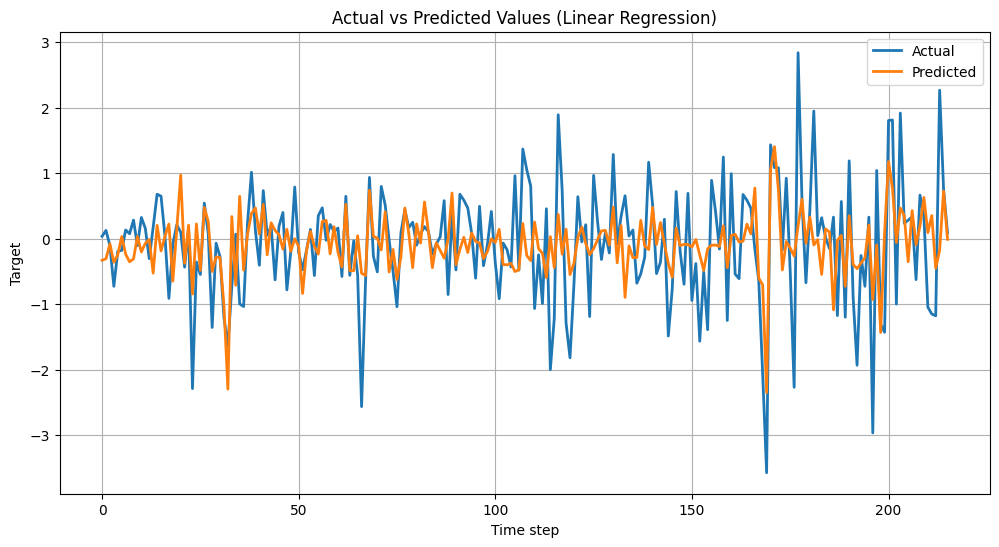

In [10]:
model_line.fit(features_train, target_train)
pred_line = model_line.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_line, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (Linear Regression)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

## Random Forest

In [11]:
grid_space_forest={
            'model__max_depth':[3,5,None],
            'model__n_estimators':[10,100],
            'model__min_samples_leaf':[2, 3, 5],
            'model__min_samples_split':[2, 3, 4, 5],
            'model__max_features': [None, 'sqrt', 'log2'],
            'model__ccp_alpha': [0.1, 0.2]

           }
#use previously created function
print('Starting model training...')
model_forest = model_training (RandomForestRegressor(random_state=RANDOMSTATE),
                        grid_space_forest, features_train, target_train.values.ravel(), tscv)

Starting model training...
The model with the best parameters: {'model__ccp_alpha': 0.1, 'model__max_depth': 3, 'model__max_features': None, 'model__min_samples_leaf': 5, 'model__min_samples_split': 2, 'model__n_estimators': 10}
The best result (RMSE): 0.8678247118049469


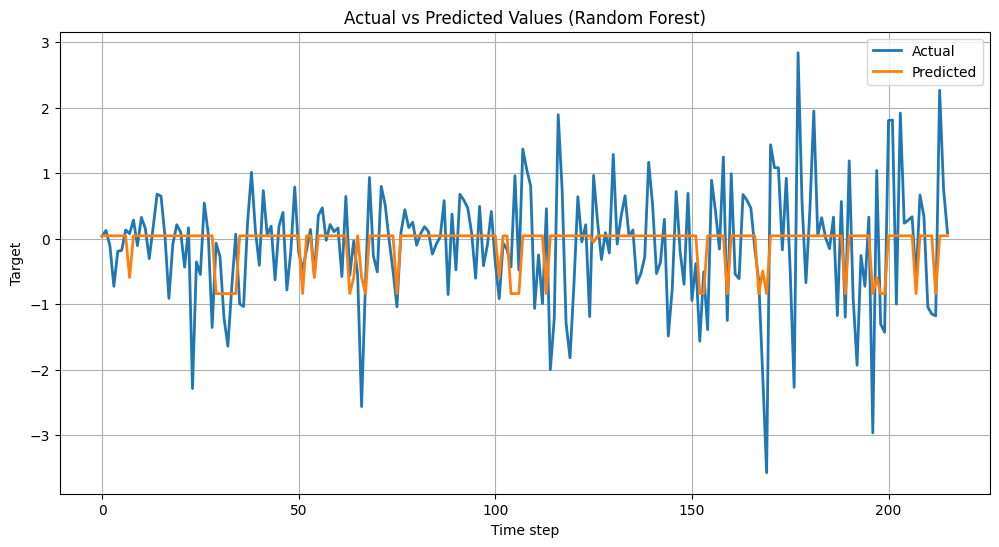

In [12]:
pred_forest = model_forest.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_forest, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (Random Forest)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##XGB Regressor

In [13]:
grid_space_xgb = {
    'model__max_depth': [3, 5, 10, None],
    'model__learning_rate': [0.01],
    'model__n_estimators': [100],
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2],
    'model__reg_alpha': [0.1, 1],
    'model__reg_lambda': [0.1, 1]
}
#use previously created function
model_xgb = model_training (xgb.XGBRegressor(n_estimators=100, learning_rate=0.1), grid_space_xgb, features_train, target_train, cv = tscv)

The model with the best parameters: {'model__colsample_bytree': 0.8, 'model__gamma': 0, 'model__learning_rate': 0.01, 'model__max_depth': 10, 'model__n_estimators': 100, 'model__reg_alpha': 0.1, 'model__reg_lambda': 0.1, 'model__subsample': 1.0}
The best result (RMSE): 0.8557991027832031


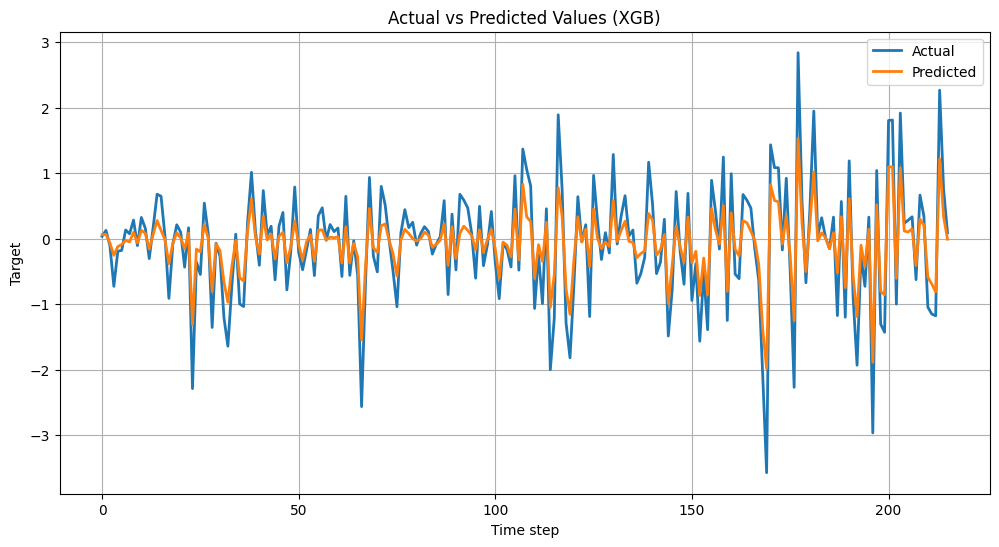

In [14]:
pred_xgb = model_xgb.predict(features_train)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_xgb, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (XGB)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##LSTM Neural Network

Creating window for a memory

In [15]:
def create_sequences(features, target, window_size):
    X, y = [], []
    for i in range(len(features) - window_size):
        X.append(features.iloc[i:i + window_size].values)
        y.append(target.iloc[i + window_size].values)
    return np.array(X), np.array(y)

window_size = 12
scaled_features_train_win, scaled_target_train_win = create_sequences(features_train, target_train, window_size)
scaled_features_test_win, scaled_target_test_win = create_sequences(features_test, target_test, window_size)
print(scaled_features_train_win.shape)
print(scaled_features_test_win.shape)

(204, 12, 15)
(2, 12, 15)


Compile model arhitecture

In [16]:
# create and compile the LSTM network
model = Sequential([
    LSTM(500,
           return_sequences=True,
            input_shape=(window_size, scaled_features_train_win.shape[2])),
    LSTM(64, return_sequences=True),
    Dropout(0.1),
    LSTM(50, return_sequences=False),  # Last LSTM returns single sequence
    Dropout(0.1),
    Dense(16, activation='relu', kernel_regularizer=l2(1e-5)),  # Extra layer to boost capacity
    Dense(1, activation='linear', bias_initializer='zeros')
])

model.compile(optimizer='adam', loss=Huber(delta=1.0))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 500)        │     1,032,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 12, 64)         │       144,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,200,473 (4.58 MB)

 Trainable params: 1,200,473 (4.58 MB)

 Non-trainable params: 0 (0.00 B)

Create checkpoint to select the best fitted epoch

In [17]:
checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

Model training

In [18]:
model.fit(scaled_features_train_win,
          scaled_target_train_win,
          epochs=5,
          batch_size=4,
          verbose=2,
          validation_split=0.2,
          callbacks=[checkpoint])

Epoch 1/5
41/41 - 6s - 148ms/step - loss: 0.2985 - val_loss: 0.6116
Epoch 2/5
41/41 - 2s - 43ms/step - loss: 0.2876 - val_loss: 0.6430
Epoch 3/5
41/41 - 1s - 34ms/step - loss: 0.2868 - val_loss: 0.6174
Epoch 4/5
41/41 - 3s - 64ms/step - loss: 0.2814 - val_loss: 0.6217
Epoch 5/5
41/41 - 3s - 71ms/step - loss: 0.2800 - val_loss: 0.6501


Make a prediction and model evaluation

In [19]:
model_LSTM = load_model('best_model.keras')
closing_price = model.predict(scaled_features_test_win)
#closing_price = scaler_target.inverse_transform(closing_price).flatten()
target_test_sliced = target_test[window_size:]
mse = mean_squared_error(target_test_sliced, closing_price)
rmse = mse**0.5
print('The average root square error in the test sample was:', rmse)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
The average root square error in the test sample was: 1.0925394170707954


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


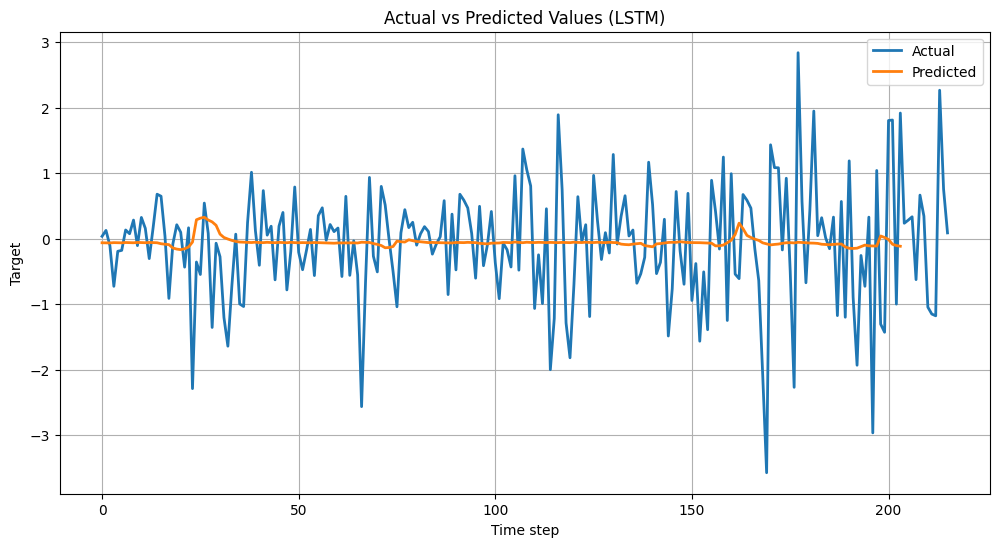

In [20]:
pred_LSTM = model_LSTM.predict(scaled_features_train_win)

plt.figure(figsize=(12, 6))
plt.plot(target_train.values, label='Actual', linewidth=2)
plt.plot(pred_LSTM, label='Predicted', linewidth=2)
plt.title('Actual vs Predicted Values (LSTM)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()

##ARIMA model

In [21]:
model_arim = ARIMA(endog=target_train, exog=features_train, order=(1, 2, 2))
model_arim = model_arim.fit()
pred_arim = model_arim.forecast(exog=features_test, steps=len(target_test))
mse_arim = mean_squared_error(target_test, pred_arim)
rmse_arim = mse_arim**0.5
print('The average root square error in the test sample was:', rmse_arim)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


The average root square error in the test sample was: 1.473316712956519


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


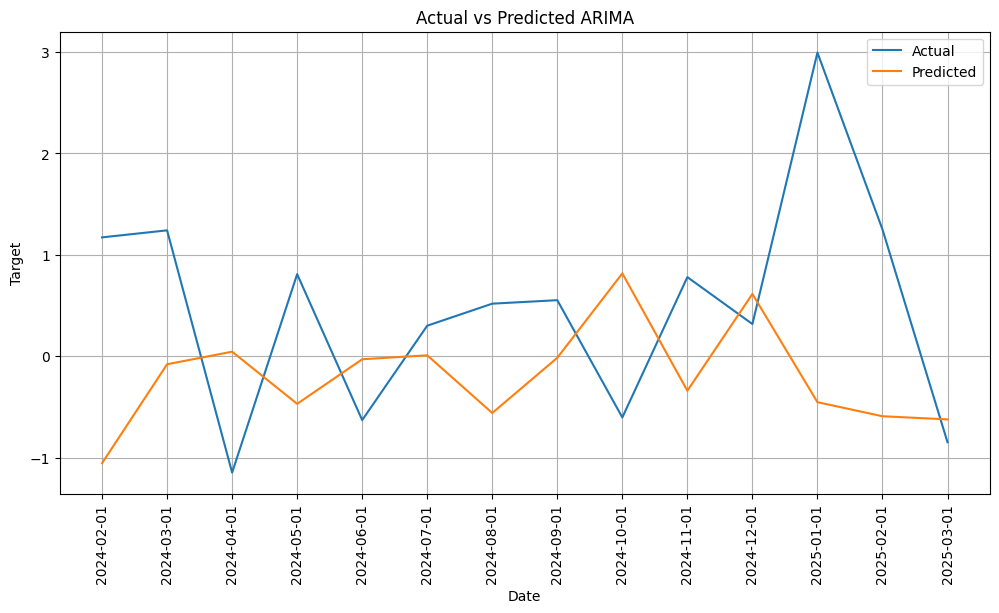

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(target_test.index, target_test.values, label='Actual')
plt.plot(target_test.index, pred_arim, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Target')
plt.xticks(rotation=90) # Rotate the x-axis tick labels
plt.title('Actual vs Predicted ARIMA')
plt.legend()
plt.grid(True)
plt.show()

# Model Testing

In [23]:
pred_xgb_test = model_xgb.predict(features_test)
pred_xgb_test_unscaled = scaler_target.inverse_transform(pred_xgb_test.reshape(-1, 1))
target_test_unscaled = scaler_target.inverse_transform(target_test.values.reshape(-1, 1))
rmse_xgb = mean_squared_error(target_test_unscaled, pred_xgb_test_unscaled)**0.5
print('The root square error in the test sample was:', rmse_xgb)

The root square error in the test sample was: 721.5232663138504


Comparison to Linear Regression

The root square error in the test sample was: 771.7131300256827


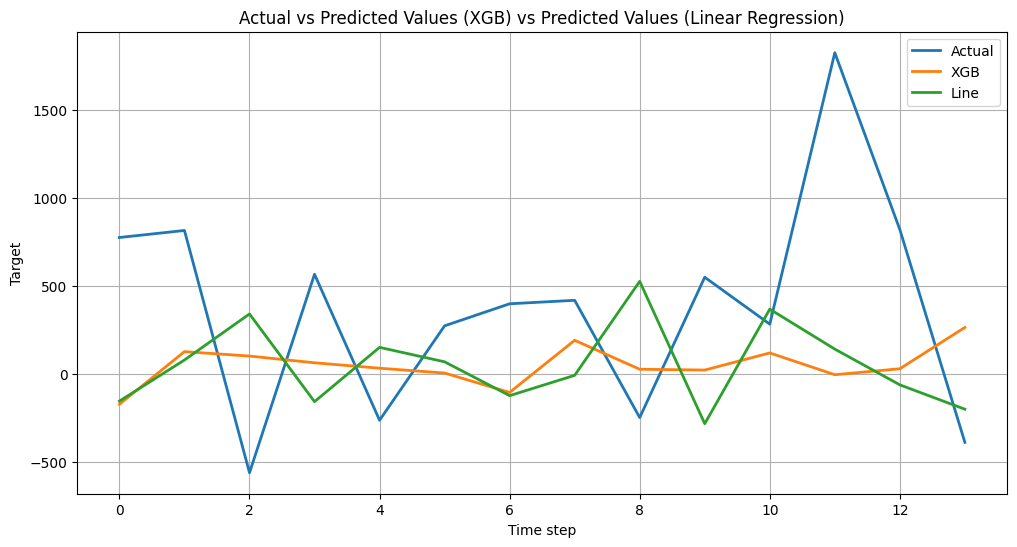

In [25]:
pred_line_test = model_line.predict(features_test)
pred_line_test_unscaled = scaler_target.inverse_transform(pred_line_test.reshape(-1, 1))
rmse_line = mean_squared_error(target_test_unscaled, pred_line_test_unscaled)**0.5
print('The root square error in the test sample was:', rmse_line)

plt.figure(figsize=(12, 6))
plt.plot(target_test_unscaled, label='Actual', linewidth=2)
plt.plot(pred_xgb_test_unscaled, label='XGB', linewidth=2)
plt.plot(pred_line_test_unscaled, label='Line', linewidth=2)
plt.title('Actual vs Predicted Values (XGB) vs Predicted Values (Linear Regression)')
plt.xlabel('Time step')
plt.ylabel('Target')
plt.legend()
plt.grid(True)
plt.show()